In [1]:
from tensorflow.keras.datasets import mnist
import sys

from tqdm import tqdm
from torch import optim
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import random
from torch.utils.data import DataLoader

import torchvision

2024-12-17 00:06:01.692853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = 'cpu'

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train = X_train[y_train == 0]
X_train = torch.Tensor(X_train).unsqueeze(1) / 256
X_test = torch.Tensor(X_test).unsqueeze(1) / 256

train_loader = DataLoader(X_train, batch_size=64, shuffle=False, drop_last=True)
val_loader = DataLoader(X_test, batch_size=64, shuffle=False)

In [4]:
class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        
        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [5]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [6]:
energy_model = CNNModel()
sampler = Sampler(energy_model, X_train.shape[1:], 64)
opt = optim.Adam(energy_model.parameters(), lr=1e-4, betas=(0, 0.999))

In [7]:
from copy import deepcopy

N_EPOCHS = 4


for i in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, data in enumerate(train_loader):
        opt.zero_grad()

        real_imgs = data
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
        
        # Obtain samples
        sampled_imgs = sampler.sample_new_exmps(steps=60, step_size=10)
        
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, sampled_imgs], dim=0)
        real_out, sampled_out = energy_model(inp_imgs).chunk(2, dim=0)
        
        # Calculate losses
        reg_loss = 0.1 * ((real_out ** 2).mean() + (sampled_out ** 2).mean())
        cdiv_loss = sampled_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss
        loss.backward()
        opt.step()

    pbar.set_description(f'{loss.detach().cpu().item():=}, {reg_loss.detach().cpu().item():=}, {cdiv_loss.detach().cpu().item():=}')





0.0020962057169526815, 6.669075901299948e-06, 0.0020895367488265038: 100%|██████████| 4/4 [34:29<00:00, 517.49s/it]


In [8]:
energy_model.eval()
start_imgs = torch.rand((10, ) + data.shape[1:])
start_imgs = start_imgs * 2 - 1
torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
imgs_per_step = Sampler.generate_samples(energy_model, start_imgs, steps=200, step_size=10, return_img_per_step=True)
torch.set_grad_enabled(False)

In [9]:
imgs_per_step.shape

torch.Size([200, 10, 1, 28, 28])

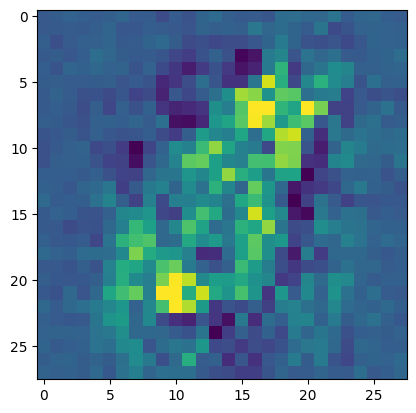

In [10]:
plt.imshow(imgs_per_step[-1, 1, 0])